In [23]:
# imports
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
##%matplotlib inline
from ipywidgets import *

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# if cloning repo and running on jupyter, only need to run this cell
# load dataset using pickle

datapath = os.path.join(os.getcwd(), 'datasets', 'Monkey Datasets', 'co_feats20.pkl') # run this line if in jupyter/cloned repo
print(datapath)
# datapath = os.path.join(os.getcwd(),'Monkey_Datasets', 'co_feats32.pkl') # run this line if colab
#datapath = "datasets\Monkey Datasets"
with open(datapath, 'rb') as f:
	data = pickle.load(f)
# quick lil dataframe to make it visual
dfs = []
for key in data.keys():
	dfs.append(pd.DataFrame(data[key]))
dfs = pd.concat(dfs, axis=1, keys=data.keys())
# group center out movements and show average trajectory, as well as corresponding neural data?

c:\Files\UM\BMIHackathon\datasets\Monkey Datasets\co_feats20.pkl


In [24]:

reachpositions = np.unique(data['targetPosition'], axis=0)

print(reachpositions)
reachpositions_interested = np.vstack((reachpositions[2,:], reachpositions[6,:]))
reachpositions_interested = reachpositions
print(reachpositions_interested)

grouped = {'neural':[], 'behavior':[]}
for position in reachpositions_interested:

	#get all trials for this target positions
	trials = np.unique(data['trialNumber'][np.argwhere((data['targetPosition'] == position).all(axis=1))])
	lens = np.stack([np.sum(data['trialNumber'] == trial) for trial in trials])

	# we need to align our trials since they are usually different lengths.
	# There are better ways to do this (time warping, etc.), but here we'll just truncate to the shortest trial of the group
	behavior = np.zeros((len(lens), np.min(lens), 6))
	neural = np.zeros((len(lens), np.min(lens), 96))
	for i, trial in enumerate(trials):
		behavior[i,:,:] = data['behavior'][(data['trialNumber'] == trial)[:,0],:][0:np.min(lens),:]
		neural[i,:,:] = data['neural'][(data['trialNumber'] == trial)[:,0],:][0:np.min(lens),:]

	grouped['behavior'].append(behavior)
	grouped['neural'].append(neural)

[[0.2 0.2]
 [0.2 0.5]
 [0.2 0.8]
 [0.5 0.2]
 [0.5 0.5]
 [0.5 0.8]
 [0.8 0.2]
 [0.8 0.5]
 [0.8 0.8]]
[[0.2 0.2]
 [0.2 0.5]
 [0.2 0.8]
 [0.5 0.2]
 [0.5 0.5]
 [0.5 0.8]
 [0.8 0.2]
 [0.8 0.5]
 [0.8 0.8]]


In [25]:
neural_list = [np.concatenate(array, axis=0) for array in grouped['neural']]
print(neural_list[0].shape)
kinematic_ends = []
for kinematic_trial in neural_list:
	if(kinematic_ends != []):
		kinematic_ends.append(kinematic_trial.shape[0]+kinematic_ends[-1])
	else:
		kinematic_ends.append(kinematic_trial.shape[0])
neural_data = np.concatenate(neural_list, axis=0)
print(neural_data.shape)

(4399, 96)
(58852, 96)


In [26]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split

class VAE(nn.Module):

    def __init__(self, input_dim=96, hidden_dim=50, latent_dim=30):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Dropout(p=0.7, inplace=False),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)   
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar
    
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x)
    kl_divergence_loss = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + kl_divergence_loss, kl_divergence_loss, reproduction_loss

def train(model, optimizer, epochs, train_loader,test_loader, batch_size_train,batch_size_test):
    model.train()
    metric_loss_train=[]
    metric_loss_test=[]
    metric_klloss_train=[]
    metric_klloss_test=[]
    metric_rploss_train=[]
    metric_rploss_test=[]

    for epoch in range(epochs):
        model.train()

        overall_train_loss = 0
        overall_test_loss = 0
        overall_train_klloss = 0
        overall_test_klloss = 0
        overall_train_rploss = 0
        overall_test_rploss = 0

        for id,x in enumerate(train_loader):
            x = x.float()

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss,kl_loss,repro_loss = loss_function(x, x_hat, mean, log_var)
            
            overall_train_loss += loss.item()
            overall_train_klloss += kl_loss.item()
            overall_train_rploss += repro_loss.item()
            
            loss.backward()
            optimizer.step()

        

        model.eval()
        with torch.no_grad():
            for id,x in enumerate(test_loader):
                x = x.float()
                x_hat, mean, log_var = model(x)
                loss,kl_loss,repro_loss = loss_function(x, x_hat, mean, log_var)
                overall_test_loss += loss.item()
                overall_test_klloss += kl_loss.item()
                overall_test_rploss += repro_loss.item()

        metric_loss_train.append(overall_train_loss/(id*batch_size_train))
        metric_loss_test.append(overall_test_loss/(id*batch_size_test))
        metric_klloss_train.append(overall_train_klloss/(id*batch_size_train))
        metric_klloss_test.append(overall_test_klloss/(id*batch_size_test))
        metric_rploss_train.append(overall_train_rploss/(id*batch_size_train))
        metric_rploss_test.append(overall_test_rploss/(id*batch_size_test))


        print("\tEpoch", epoch + 1, "\tAverage Train Loss: ", overall_train_loss/(id*batch_size_train), "\tAverage Test Loss: ", overall_test_loss/(id*batch_size_test))
        
    return metric_loss_train,metric_loss_test,metric_klloss_train,metric_klloss_test,metric_rploss_train,metric_rploss_test


In [50]:
train_percentage = 0.7

train_set = neural_data[:int(neural_data.shape[0] * train_percentage), :]
test_set = neural_data[int(neural_data.shape[0] * train_percentage):, :]

batch_size_train = 1024
batch_size_test = 512

trainSetLoader = DataLoader(train_set,
                             batch_size = batch_size_train,
                             shuffle=True)
testSetLoader = DataLoader(test_set,
                             batch_size = batch_size_test,
                             shuffle=True)

model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

mltrain,mltest,mkltrain,mkltest,mrptrain,mrptest = train(model, optimizer, 200, trainSetLoader, testSetLoader,batch_size_train,batch_size_test)


	Epoch 1 	Average Train Loss:  1.1312038657419823 	Average Test Loss:  0.5073717990342308
	Epoch 2 	Average Train Loss:  0.3218402687241049 	Average Test Loss:  0.4529409680296393
	Epoch 3 	Average Train Loss:  0.294432884630035 	Average Test Loss:  0.4369775503873825
	Epoch 4 	Average Train Loss:  0.2813376197043587 	Average Test Loss:  0.42609113893088174
	Epoch 5 	Average Train Loss:  0.27341877581442103 	Average Test Loss:  0.4209895677426282
	Epoch 6 	Average Train Loss:  0.26900918781757355 	Average Test Loss:  0.4172000814886654
	Epoch 7 	Average Train Loss:  0.2657296162317781 	Average Test Loss:  0.4142825656077441
	Epoch 8 	Average Train Loss:  0.2631046149660559 	Average Test Loss:  0.41186802264522104
	Epoch 9 	Average Train Loss:  0.2612336028148146 	Average Test Loss:  0.41027970173779654
	Epoch 10 	Average Train Loss:  0.2598603771013372 	Average Test Loss:  0.4088224926415612
	Epoch 11 	Average Train Loss:  0.2585783530684078 	Average Test Loss:  0.40752219540231366
	Ep

<function matplotlib.pyplot.show(close=None, block=None)>

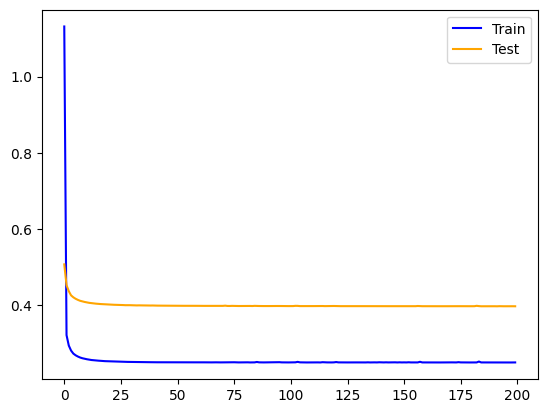

In [51]:
plt.plot(mltrain,color='blue')
plt.plot(mltest,color='orange')
plt.legend(['Train','Test'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

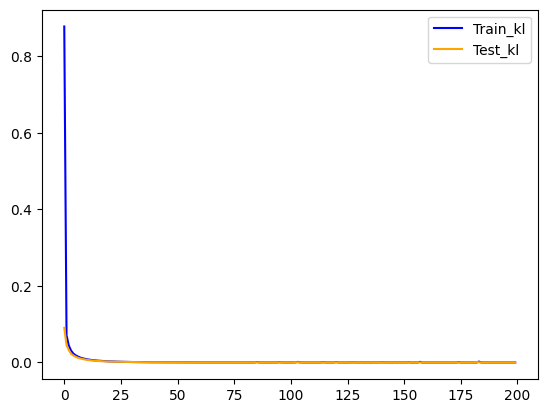

In [52]:
plt.plot(mkltrain,color='blue')
plt.plot(mkltest,color='orange')
plt.legend(['Train_kl','Test_kl'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

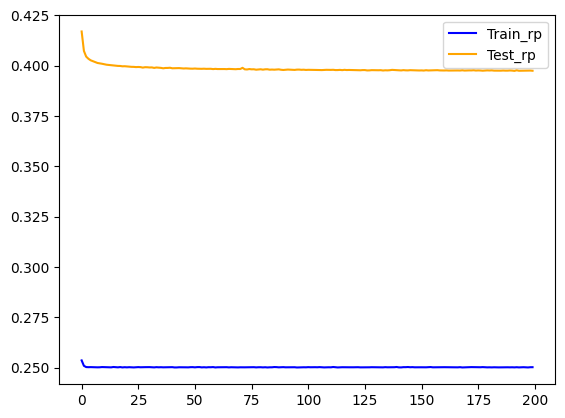

In [53]:
plt.plot(mrptrain,color='blue')
plt.plot(mrptest,color='orange')
plt.legend(['Train_rp','Test_rp'])
plt.show

torch.Size([5883, 2])


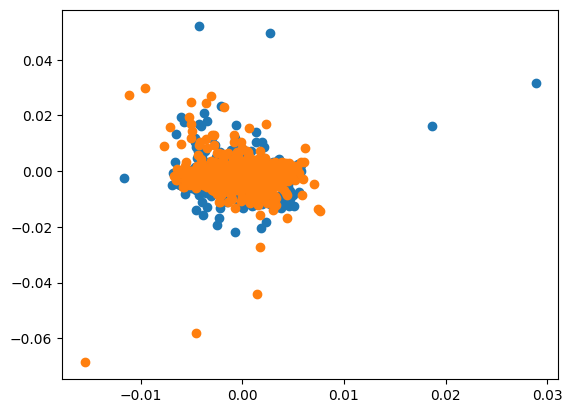

In [56]:
def given_index_return_split(index1,index2,endpoints,data):
    if(index1 != 0):
        data1 = data[endpoints[index1-1]:endpoints[index1]]
    else:
        data1 = data[0:endpoints[index1]]
    data2 = data[endpoints[index2-1]:endpoints[index2]]
    return data1,data2

neural_data_first, neural_data_second = given_index_return_split(2,6,kinematic_ends,neural_data)

vae_out_first_0,vae_out_first_1 = model.encode(torch.tensor(neural_data_first).float())
vae_out_second_0,vae_out_second_1 = model.encode(torch.tensor(neural_data_second).float())
print(vae_out_first_0.shape)
plt.scatter(vae_out_first_0[:,0].detach().numpy(),vae_out_first_0[:,1].detach().numpy())
plt.scatter(vae_out_second_0[:,0].detach().numpy(),vae_out_second_0[:,1].detach().numpy())
plt.show
input_pca_first = vae_out_first_1.detach().numpy()
input_pca_second = vae_out_second_1.detach().numpy()

(array([  0.33246289,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.33246289,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.

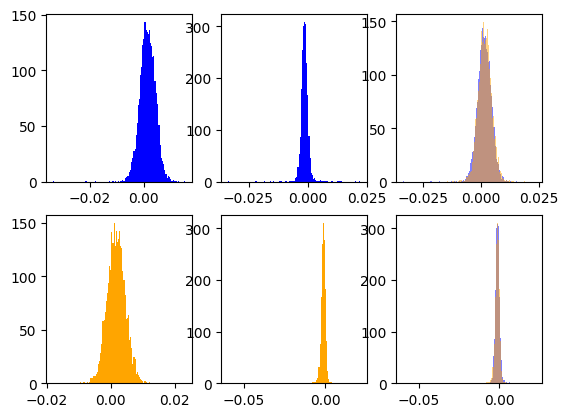

In [57]:

fig,ax  = plt.subplots(2,3)
ax[0,0].hist(input_pca_first[:,0], density=True, bins=120,color='Blue')
ax[1,0].hist(input_pca_second[:,0], density=True, bins=120,color='Orange')
ax[0,1].hist(input_pca_first[:,1], density=True, bins=120,color='Blue')
ax[1,1].hist(input_pca_second[:,1], density=True, bins=120,color='Orange')

ax[0,2].hist(input_pca_first[:,0], density=True, bins=120,color='Blue',alpha=0.5)
ax[0,2].hist(input_pca_second[:,0], density=True, bins=120,color='Orange',alpha=0.5)
ax[1,2].hist(input_pca_first[:,1], density=True, bins=120,color='Blue',alpha=0.5)
ax[1,2].hist(input_pca_second[:,1], density=True, bins=120,color='Orange',alpha=0.5)